In [ ]:
# one shot import all we need for this post
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
#from fbprophet import Prophet

In [6]:
np.random.seed(25)
n_changepoints = 10
t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False)) # sample change points

A = (t[:, None] > s) * 1

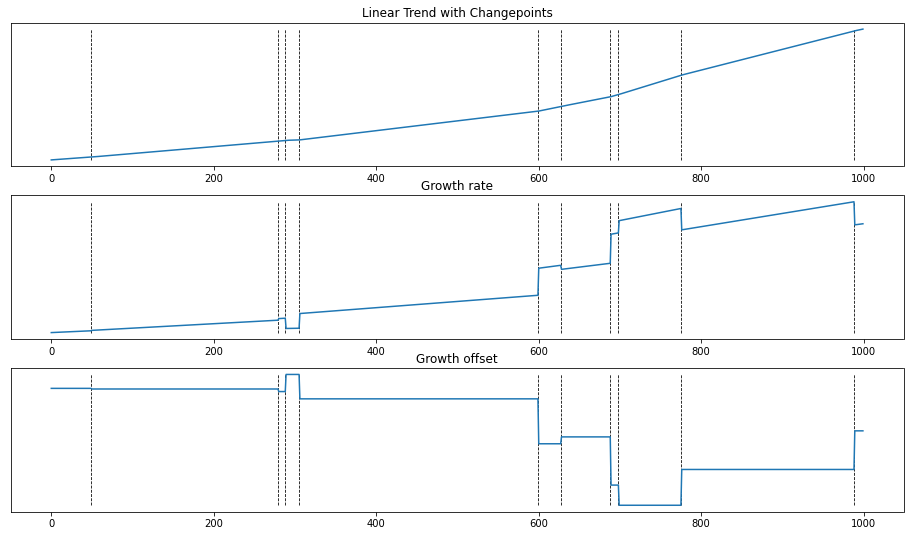

In [21]:
np.random.seed(25)
n_changepoints = 10
t = np.arange(1000)
s = np.sort(np.random.choice(t, n_changepoints, replace=False)) # sample change points

A = (t[:, None] > s) * 1  # broadcast for each change point
delta = np.random.normal(size=n_changepoints) # sample change 
k = 1
m = 5

growth = (k + A @ delta) * t  # 
gamma = -s * delta
offset = m + A @ gamma
trend = growth + offset

plt.figure(figsize=(16, 3 * 3))
n = 310
i = 0
for t, f in zip(['Linear Trend with Changepoints', 'Growth rate', 'Growth offset'],
                [trend, growth, offset]):
    i += 1
    plt.subplot(n + i)
    plt.title(t)
    plt.yticks([])
    plt.vlines(s, min(f), max(f), lw=0.8, linestyles='--')
    plt.plot(f)


In [32]:
trend.shape

(1000,)

In [22]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

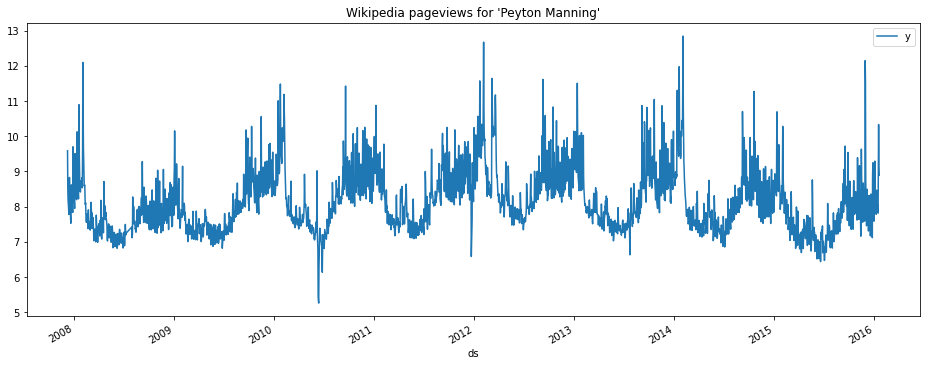

In [23]:
df = pd.read_csv('data/peyton_manning.csv')
# Make sure we work with datetime types
df['ds'] = pd.to_datetime(df['ds'])
# Scale the data
df['y_scaled'] = df['y'] / df['y'].max()
df['t'] = (df['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())
df.plot(x='ds', y='y', figsize=(16, 6), title="Wikipedia pageviews for 'Peyton Manning'")

In [24]:
def trend_model(m, t, n_changepoints=25, changepoints_prior_scale=0.05, 
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time.
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/ None) The scale of the Laplace prior on the delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on the growth.
    :param changepoint_range: (flt) Proportion of history in which trend changepoints will be estimated. 
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s

# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, df['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=df['y_scaled'])

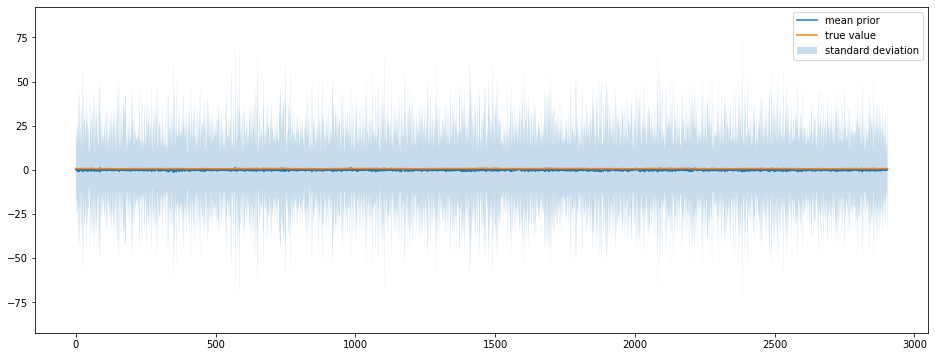

In [25]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(samples=5000, model=m, vars=['obs'])['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(df['y_scaled'], label='true value')
    plt.legend()

# And run the sanity check
sanity_check(m, df)

Text(5.194994994994995, 0.42870445777845795, 'mode')

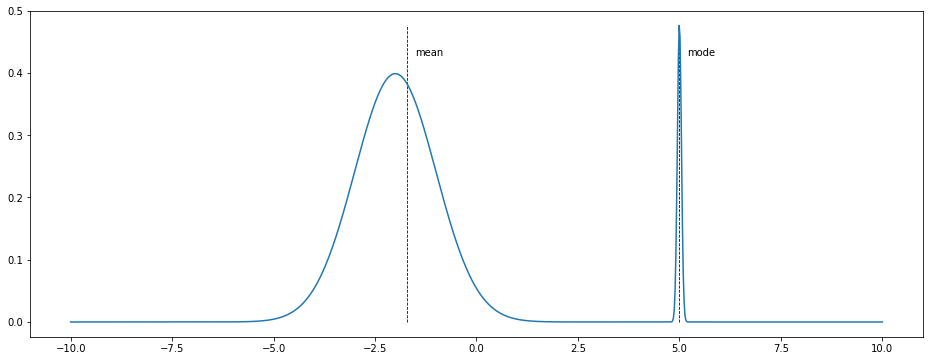

In [26]:
x = np.linspace(-10, 10, 1000)
pdf = stats.norm.pdf(x, -2, 1) + stats.norm.pdf(x, 5, 0.05) * 0.06
mode = pdf.max()
mean = pdf.mean()

# find the mean of the integrated probablity density function
idx_mean = np.argmin(np.abs(np.cumsum(pdf) - np.cumsum(pdf).mean()))
idx_mode = pdf.argmax()
plt.figure(figsize=(16, 6))
plt.plot(x, pdf)
plt.vlines([x[idx_mean], x[idx_mode]], 0, mode, lw=0.8, linestyles='--')
plt.annotate('mean', (x[idx_mean] + 0.2, mode * 0.9))
plt.annotate('mode', (x[idx_mode] + 0.2, mode * 0.9))


logp = 4,028.9, ||grad|| = 84.509: 100%|██████████| 1025/1025 [00:01<00:00, 555.30it/s]


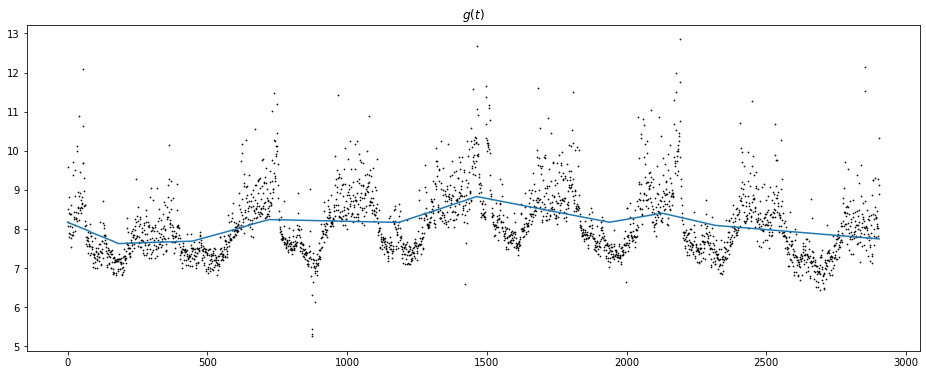

In [27]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], df['t'], s, A) * df['y'].max()

plt.figure(figsize=(16, 6))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(df.shape[0]), df.y, s=0.5, color='black')

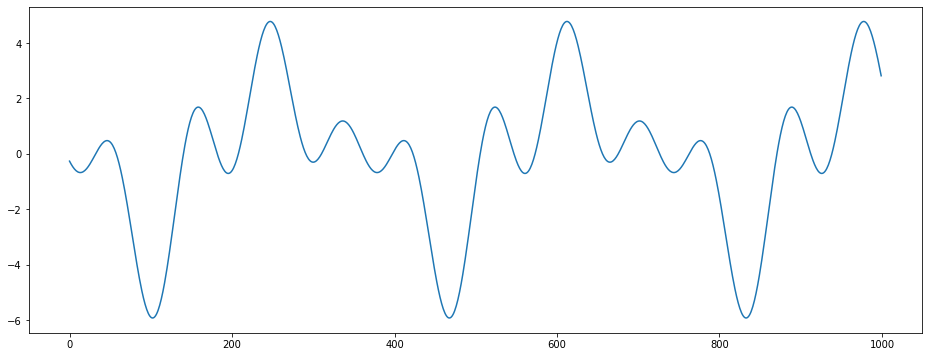

In [28]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
plt.figure(figsize=(16, 6))
plt.plot(fourier_series(t, 365.25, n) @ beta)

In [29]:
def seasonality_model(m, df, period='yearly', seasonality_prior_scale=10):
    
    if period == 'yearly':
        n = 10
        # rescale the period, as t is also scaled
        p = 365.25 / (df['ds'].max() - df['ds'].min()).days
    else:  # weekly
        n = 3
        # rescale the period, as t is also scaled
        p = 7 / (df['ds'].max() - df['ds'].min()).days
    x = fourier_series(df['t'], p, n)
    with m:
        beta = pm.Normal(f'beta_{period}', mu=0, sd=seasonality_prior_scale, shape=2 * n)
    return x, beta

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, df['t'], changepoints_prior_scale=None)
    x_yearly, beta_yearly = seasonality_model(m, df, 'yearly')
    x_weekly, beta_weekly = seasonality_model(m, df, 'weekly')
    
    y += det_dot(x_yearly, beta_yearly) + det_dot(x_weekly, beta_weekly)
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=df['y_scaled'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, m, delta, tau, k]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [17:05<00:00,  1.95draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f86633ba8>,
      dtype=object)

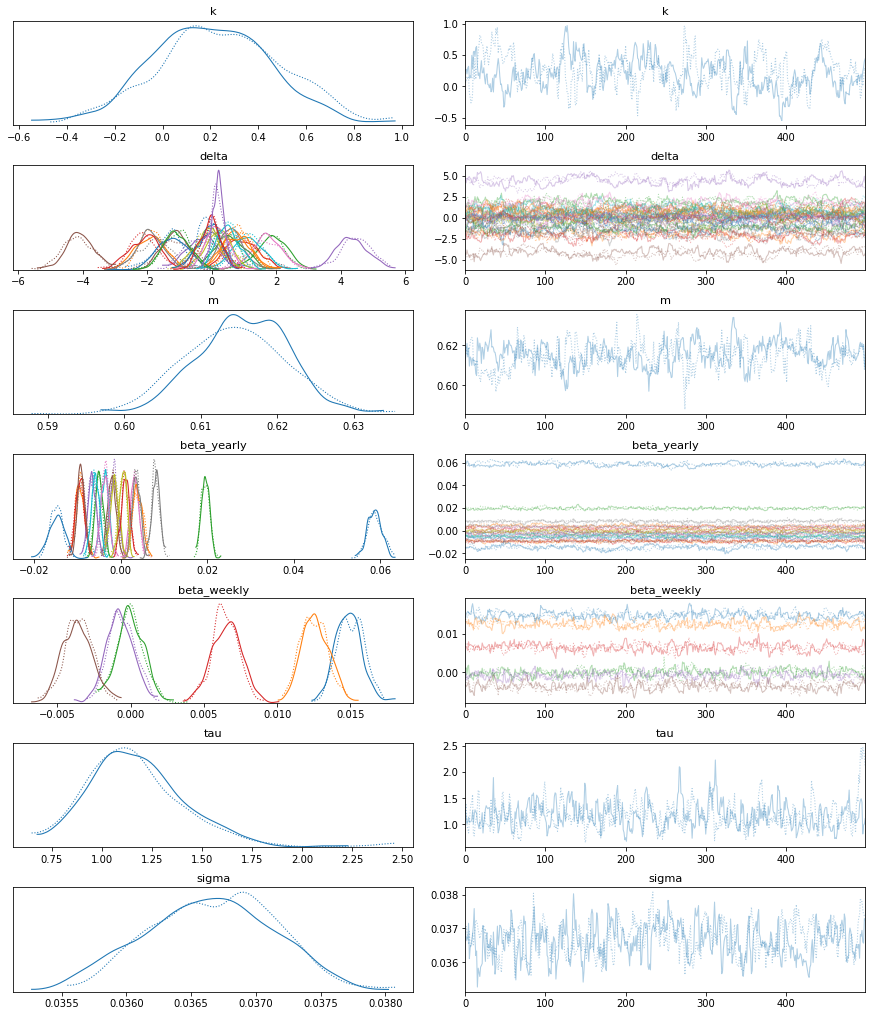

In [30]:
with m:
    trace = pm.sample(500)
pm.traceplot(trace)


In [ ]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
beta_yearly = trace['beta_yearly']
beta_weekly = trace['beta_weekly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']

# determine the posterior by evaulating all the values in the trace.
trend_posterior = ((k + np.dot(A, delta.T)) * df['t'][:, None] + m + np.dot(A, (-s * delta).T)) * df['y'].max()

yearly_posterior = det_seasonality_posterior(beta_yearly, x_yearly) * df['y'].max()
weekly_posterior = det_seasonality_posterior(beta_weekly, x_weekly) * df['y'].max()

date = df['ds'].dt.to_pydatetime()
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior + yearly_posterior + weekly_posterior).mean(1), lw=0.5)
plt.scatter(date, df['y'], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], yearly_posterior.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(yearly_posterior, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

In [ ]:
n_samples = 1000
days = 150
history_points = df.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'ds': pd.date_range(df['ds'].min(), 
                                           df['ds'].max() + pd.Timedelta(days, 'D'), 
                        df.shape[0] + days)})
future['t'] = (future['ds'] - df['ds'].min()) / (df['ds'].max() - df['ds'].min())

# vector distributions
beta_yearly = trace['beta_yearly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * df['y'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['ds'].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Trend forecasts uncertainty')
plt.plot(date, trend_forecast.mean(0))
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)